In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

## Data Exploration

In [2]:
train = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
print(train.info())
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
print('number of shops: ', train['shop_id'].nunique())
print('number of items: ', train['item_id'].nunique())
print('number of months: ', train['date_block_num'].nunique())
print('predict how many of each item are sold per month')

number of shops:  60
number of items:  21807
number of months:  34
predict how many of each item are sold per month


### Remove outliers

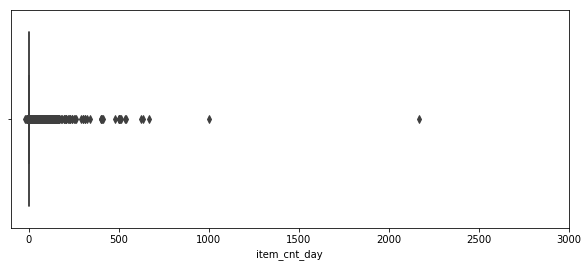

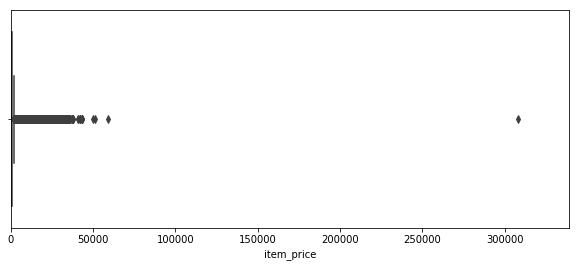

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

train = train[train.item_price<100000]
train = train[train.item_cnt_day<800]

### Check if the price values are "healty"

In [5]:
median = train['item_price'].median()  # compute the median value
train.loc[train.item_price<0, 'item_price'] = median
train.loc[train.item_cnt_day<0, 'item_cnt_day'] = 0

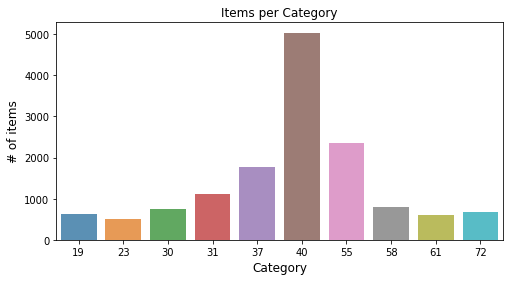

In [6]:
items.head()
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index() # old index is added as a column, and a new sequential index is used
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Single Series Analisys 


Total sales of the company in a time interval of 33 months (almost 3 years)


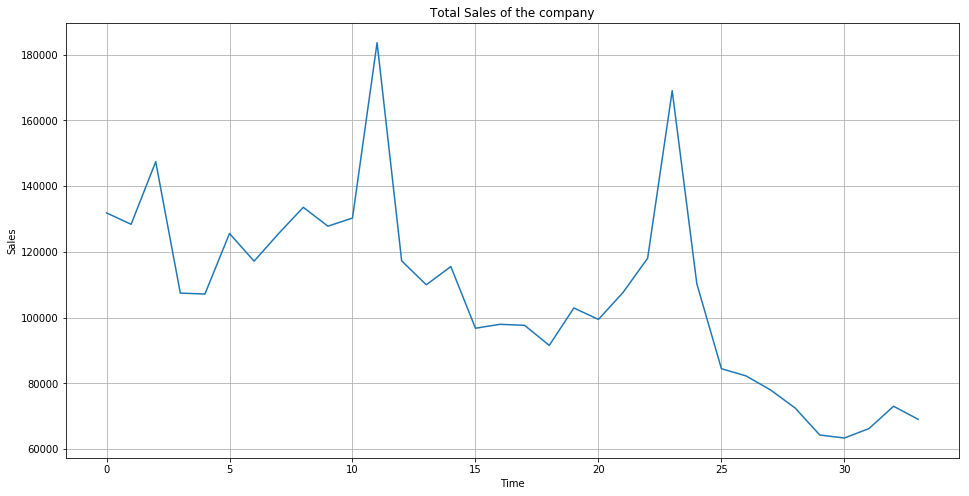

In [7]:
import statsmodels as sm

ts=train.groupby(["date_block_num"])["item_cnt_day"].sum() # extract the count of the items sold per month 
ts.astype('float')
plt.figure(figsize=(16,8))
plt.grid()
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);
print('Total sales of the company in a time interval of 33 months (almost 3 years)')

### Rolling Mean and Rolling Standard Deviation:

* **Moving Average** (**rolling average** or **running average**) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles. The threshold between short-term and long-term depends on the application, and the parameters of the moving average will be set accordingly. Mathematically, a moving average is a type of convolution and so it can be viewed as an example of a low-pass filter used in signal processing. When used with non-time series data, a moving average filters higher frequency components without any specific connection to time, although typically some kind of ordering is implied. Viewed simplistically it can be regarded as smoothing the data. 
* **Rolling Standard Deviation** is derived by calculating an ‘n’ time period Simple Moving Average of the data item. It then sums the squares of the difference between the data item and its Moving Average over each of the preceding ‘n’ time periods. Finally, it divides this sum by ‘n’ and calculates the square root of this result. It is a measure that is used to quantify the amount of variation of a set of data from the mean. Low standard deviation indicates that the data points tend to be close to the mean while high standard deviation indicates that the data points are spread out over a wider range of values.


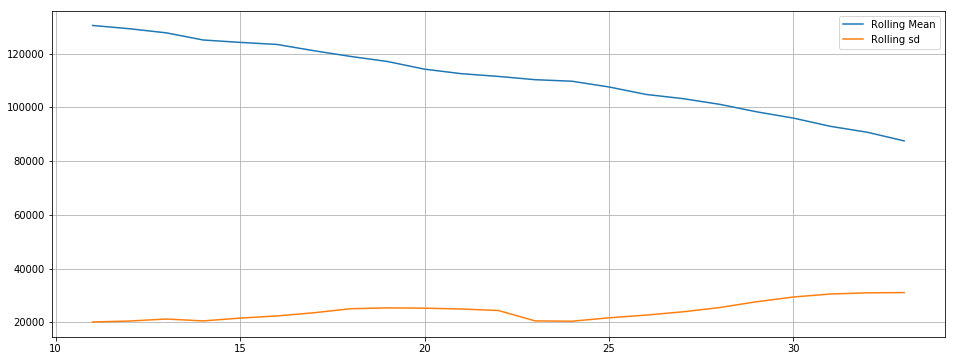

In [8]:
plt.figure(figsize=(16,6))
plt.grid()
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

There is an obvious "**seasonality**" (Eg: peak sales around a time of year) and a decreasing "**Trend**".

### Trend, Seasonality and Residuals decomposition
Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.
A useful abstraction for selecting forecasting methods is to break a time series down into **systematic** and **unsystematic** components. 

* Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
* Unsystematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:
* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.

* Residuals: in forecasting you want to predict the value of a series at, e.g., the next time instant. That means you’re interested in finding one step ahead prediction value of a given series. When you compare this predicted value with the observed one whatever difference you get is called Residual. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model (MA) of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. 

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

### Additive regression model
An additive model suggests that the components are added together as follows:

	y(t) = Level + Trend + Seasonality + Noise
    
An additive model is linear where changes over time are consistently made by the same amount

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

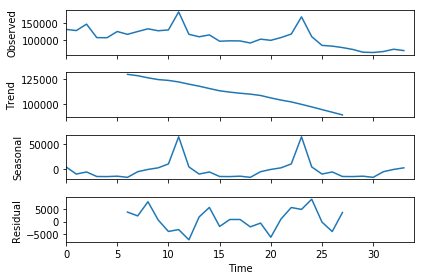

In [10]:
decompose_result_add = seasonal_decompose(ts.values,freq=12, model='additive')
fig = decompose_result_add.plot()

### Multiplicative regression model
A multiplicative model suggests that the components are multiplied together as follows:

    y(t) = Level * Trend * Seasonality * Noise

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

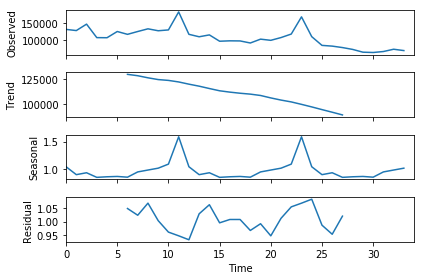

In [11]:
decompose_result_mul = seasonal_decompose(ts.values,freq=12, model='multiplicative')
fig = decompose_result_mul.plot()

### Conclusions:
The results of the two decompositions are quite similar, we choose the simplest model -> **Additive**

## Validate Process Stationarity:
https://www.statisticshowto.datasciencecentral.com/

**Stationary process** (a.k.a. a strict/strictly stationary process or strong/strongly stationary process): Stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.

Since **stationarity** is an assumption underlying many statistical procedures used in time series analysis, non-stationary data is often transformed to become stationary. The most common cause of violation of stationarity is a trend in the mean, this concept also refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality). 

There are multiple tests that can be used to check stationarity.
* ADF(Augmented Dickey Fuller Test) --> most common
* KPSS
* PP (Phillips-Perron test)

### ADF(Augmented Dicky Fuller Test)
The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. 

**Unit roots** can cause unpredictable results in your time series analysis and is a stochastic trend in a time series, sometimes called a “random walk with drift”; If a time series has a unit root, it shows a systematic pattern that is unpredictable.

The Augmented Dickey-Fuller test can be used with serial correlation. The ADF test can handle more complex models than the Dickey-Fuller test, and it is also more powerful. That said, it should be used with caution because—like most unit root tests—it has a relatively high **Type I error rate**.

A Type I error (sometimes called a Type 1 error), is the incorrect rejection of a true **null hypothesis**. 

The null hypothesis H0 is a commonly accepted fact, in this case that there is a unit root. 

You need to choose a **Lag Length** to run the test. The lag length should be chosen so that the residuals aren’t auto correlated. You’ve got several options for choosing lags: Minimize Akaike’s information criterion (**AIC**) or Bayesian information criterion (**BIC**), or drop lags until the last lag is statistically significant.

* Null hypothesis:  there is a unit root.
* Alternate hypothesis: the time series is stationary (or trend-stationary).


In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity_ADF(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADFT statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity_ADF(ts)

# returns:
#    adf (float) – Test statistic

#    pvalue (float) – MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

#    usedlag (int) – Number of lags used

#    nobs (int) – Number of observations used for the ADF regression and calculation of the critical values

#    critical values (dict) – Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

#    icbest (float) – The maximized information criterion if autolag is not None.

#    resstore (ResultStore, optional) – A dummy class with results attached as attributes


Results of Dickey-Fuller Test:
ADFT statistic                 -2.372264
p-value                         0.149718
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


### Results interpretation:
It’s usually up to you to interpret the results. In general, a **p-value** of less than 5% means you can reject the null hypothesis that there is a unit root. You can also compare the calculated DFT (Dickey Fuller Test) statistic with a tabulated **critical value**. If the **ADFT statistic** is more negative than the table value, reject the null hypothesis of a unit root. Note: The more negative the DF test statistic, the stronger the evidence for rejecting the null hypothesis of a unit root.

* p-value:  p-value or probability value or significance is, for a given statistical model, the probability that, when the null hypothesis is true, the statistical summary (such as the absolute value of the sample mean difference between two compared groups) would be greater than or equal to the actual observed results.

Looking at the ADF results we have a p-value that is above 5%, this suggest that we can't reject the null hypothesis, but also we can see that the ADF test value is above 5%. For now we CANNOT REJECT null hypothesis, hence we can't conclude that our process is stationary.

### KPSS

**Kwiatkowski–Phillips–Schmidt–Shin (KPSS)** tests are used for testing a null hypothesis that an observable time series is stationary around a deterministic trend (i.e. **trend-stationary**) against the alternative of a unit root.

Contrary to most unit root tests, the presence of a unit root is not the null hypothesis but the alternative. Additionally, in the KPSS test, the absence of a unit root is not a proof of stationarity but, by design, of trend-stationarity. This is an important distinction since it is possible for a time series to be non-stationary, have no unit root yet be trend-stationary.

Use this test to figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.

A major disadvantage for the KPSS test is that it has a high rate of Type I errors (it tends to reject the null hypothesis too often). If attempts are made to control these errors (by having larger p-values), then that negatively impacts the test’s power.
One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is. 

Data is normally **log-transformed** before running the KPSS test, to turn any exponential trends into linear ones.

* Null hypothesis: the data is stationary (around a constant or around a trend).
* Alternate hypothesis: the data is not stationary.


In [13]:
from statsmodels.tsa.stattools import kpss

def test_stationarity_KPSS(timeseries):
    
    #Perform KPSS test:
    print('Results of KPSS Test:')
    dftest = kpss(np.log(timeseries),regression='ct')  # ---> 'ct' set " data is stationary around a trend" as null hypothesis
    dfoutput = pd.Series(dftest[0:3], index=['kpss_stat','p-value','#Lags Used'])
    for key,value in dftest[3].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity_KPSS(ts)

Results of KPSS Test:
kpss_stat                 0.166687
p-value                   0.032761
#Lags Used               10.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


### Results interpretation:
The KPSS test authors derived one-sided LM statistics for the test. If the LM statistic is greater than the critical value (given in the table below for alpha levels of 10%, 5% and 1%), then the null hypothesis is rejected; the series is non-stationary.

<img src="kpss.png">

We CAN reject null hypothesis, meaning that this test is suggesting us that our time series **has a trend**. This also confirm the outcome of the Augmented Dickey-Fuller Test, in fact if our time series has a trend we can't conclude for stationarity property, we will repeat the ADF test after de-trending and de-seasonalization of the process.

we can also look at the p-value returned by the test and compare it to your chosen alpha level. For example, a p-value of 0.02 (2%) would cause the null hypothesis to be rejected at an alpha level of 0.05 (5%).

## Trend and Seasonality removal from time series
https://machinelearningmastery.com/time-series-seasonality-with-python/

From a machine learning perspective, a trend and or seasonality in data represents two opportunities:

* **Remove Information**: To remove systematic information that distorts the relationship between input and output variables.
* **Add Information**: To add systematic information to improve the relationship between input and output variables.

Specifically, a trend or a seasonality can be removed from your time series data (and data in the future) as a data preparation and cleaning exercise. This is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models.

There are many types of seasonality. Some obvious examples include; time of day, daily, weekly, monthly, annually, and so on. As such, identifying whether there is a seasonality component in your time series problem is subjective.

The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

In [14]:
# detrending by difference:

# create a differenced series
def difference_ts(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [15]:
ts_deseas = difference_ts(ts.values, 12) # assuming annual seasonality
ts_detrend = difference_ts(ts.values)

print('ts_original length:', len(ts),' ts_detrended length:', len(ts_detrend), ' ts_seasonalised length:', len(ts_deseas))

# Using scipy: Subtract the line of best fit
# from scipy import signal
# other methods
#ts_detrend = signal.detrend(ts.values) # detrend by Subtract the line of best fit
#ts_deseas = ts_detrend/decompose_result_add.seasonal

ts_original length: 34  ts_detrended length: 33  ts_seasonalised length: 22


Results of Dickey-Fuller Test:
ADFT statistic                 -3.181380
p-value                         0.021088
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
None


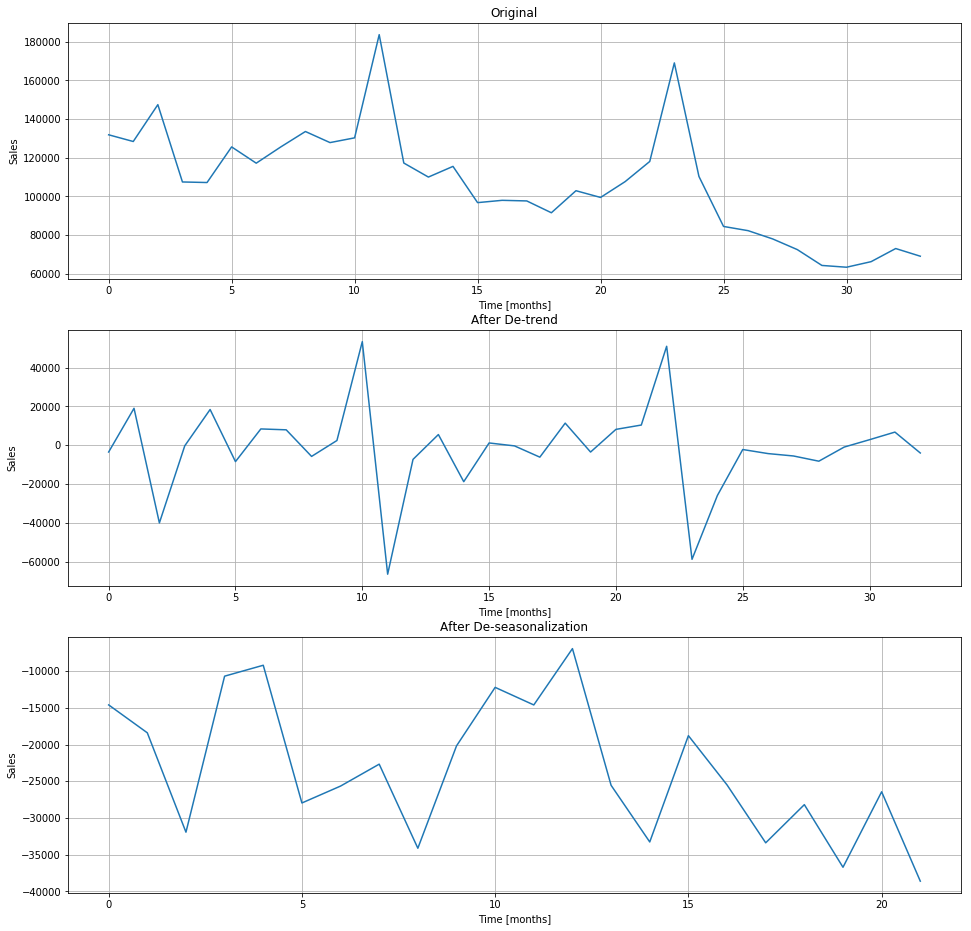

In [16]:
ts.astype('float')
ts_detrend.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.grid()
plt.title('Original')
plt.xlabel('Time [months]')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.grid()
plt.title('After De-trend')
plt.xlabel('Time [months]')
plt.ylabel('Sales')
plt.plot(ts_detrend)
plt.subplot(313)
plt.grid()
plt.title('After De-seasonalization')
plt.xlabel('Time [months]')
plt.ylabel('Sales')
plt.plot(ts_deseas)
plt.plot()
print(test_stationarity_ADF(ts_deseas))

### conclusion:
After de-seasonalization and de-trending of the process both ADF and KPSS test confirm that our process is **stationary**.

## Forecasting
https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06

**ARIMA** stands for **Auto Regressive Integrated Moving Average**. There are seasonal and Non-seasonal ARIMA models that can be used for forecasting time series. First let's analyse the meaning of each single component of an ARIMA model:

* **AR**: Auto-Regressive model that uses the dependent relationship between an observation and some number of lagged observations, specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). A purely AR model forecasts only using a combination of the past values sorta like linear regression where the number of AR terms used is directly proportional to the number of previous periods taken into consideration for the forecasting.
                                              x[t] = a0 + a1*x[t-1] + w[t]  (w is a white gaussian noise)

* **MA**: Moving-Average model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations, specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term. Considering the presence of random jumps in the time series plot whose effect is felt in two or more consecutive periods, these jumps represent the error calculated in our ARIMA model and represent what the MA component would lag for. A purely MA model would smooth out these sudden jumps like the exponential smoothing method. MA terms are lagged forecast errors in prediction equation.
                                                x[t] = b0*w[t-1] + w[t]
* **I**: Integrated, use of differencing of raw observations inorder to make the time series stationary, is a preprocessing procedure to “stationarize” as we did above.

The primary difference between an AR and MA model is based on the correlation between time series objects at different time points. The covariance between x(t) and x(t-n) is zero for MA models. However, the correlation of x(t) and x(t-n) gradually declines with n becoming larger in the AR model.

This means that the moving average(MA) model does not uses the past forecasts to predict the future values whereas it uses the errors from the past forecasts. While, the autoregressive model(AR) uses the past forecasts to predict future values.

A standard notation is **ARIMA(p,d,q)** where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.
A value of 0 can be used for a parameter, which indicates to not use that element of the model. In other words, ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Nonseasonal ARIMA(p,d,q) requires three parameters and is traditionally configured manually.

### Autocorrelation function plot (ACF):

Autocorrelation refers to how correlated a time series is with its past values whereas the ACF is the plot used to see the correlation between the points, up to and including the lag unit. In ACF, the correlation coefficient is in the x-axis whereas the number of lags is shown in the y-axis.

Given the fact that normally in an ARIMA model, we make use of either the AR term or the MA term. We use both of these terms only on rare occasions. We use the ACF plot to decide which one of these terms we would use for our time series.

* Positive Autocorrelation at lag 1 ---> AR model
* Negative Autocorrelation at lag 1 ---> MA model

By inspecting PACF it is possible to find out the order of MA terms:

* **MA(p)**: e.g. If we observe that the ACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross a predefined significance limit we can assume p=2 (or p=1).


### Partial Autocorrelation Function Plot (PACF)

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed, it represent the correlation at lag k that results after removing the effect of any correlations due to the terms at shorter lags.

* PACF plot drops off at lag n ---> AR model
* PACF plot drops off gradually ---> MA model

By inspecting PACF it is possible to find out the order of AR terms:

* **AR(p)**: e.g. If we observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross a predefined significance limit we can assume p=2 (or p=1).

In [17]:
from statsmodels.tsa.stattools import acf, pacf

def plot_ACF_PAFC(ts, lags = 10):
    lag = lags
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.grid()
    plt.xlabel('Lags')
    plt.title('Autocorrelation function plot (ACF)')
    plt.stem(acf(ts, nlags = lag))
    plt.subplot(122)
    plt.grid()
    plt.title('Partial Autocorrelation Function Plot (PACF)')
    plt.xlabel('Lags')
    plt.stem(pacf(ts, nlags = lag, method='ywm'))  # ---> default Yule-Walker method
    plt.plot()
    return

### Example 1: AR process

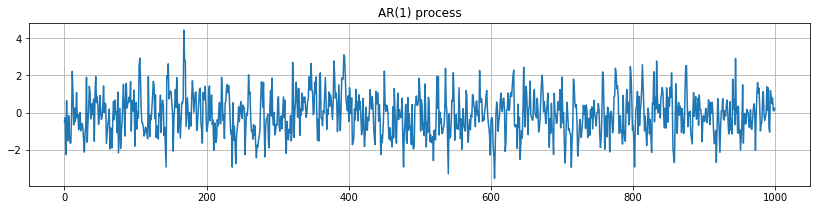

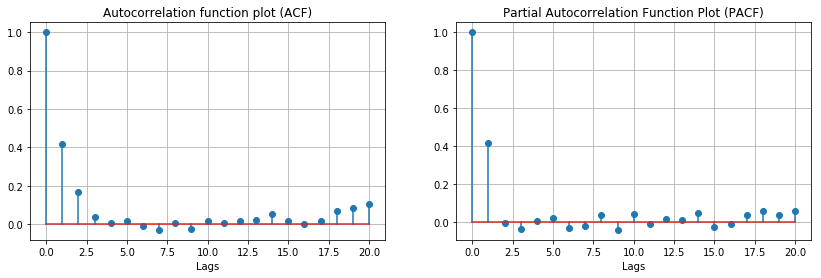

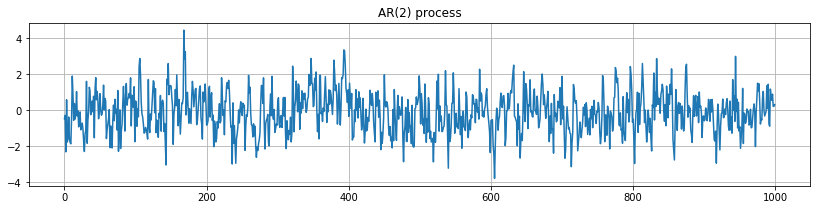

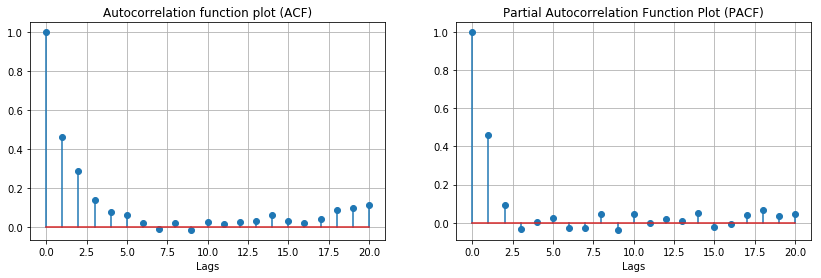

In [18]:
n_samples = int(1000) # number of samples
# alpha parameter
c = 0
a1 = 0.444 
# random signal
np.random.seed(1)
x = np.random.normal(size=n_samples)
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up AR(1) process
for t in range(n_samples):
    x[t] = c + a1*x[t-1] + w[t]
    
# plot AR    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('AR(1) process')
plt.plot(x)
plot_ACF_PAFC(x, 20)

n_samples = int(1000) # number of samples
# alpha parameter
c = 0
a1 = 0.444
a2 = 0.1
# random signal
np.random.seed(1)
x = np.random.normal(size=n_samples)
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up AR(2) process
for t in range(n_samples):
    x[t] = c + a2*x[t-2] + a1*x[t-1] + w[t]
    
# plot AR    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('AR(2) process')
plt.plot(x)
plot_ACF_PAFC(x,20)


### Analysis of the generated AR processes:
* Both AR(1) and AR(2) have positive Autocorrelation at lag = 1
* ACF shape exponentially decaying to zero
* PACF drop of at lag 1 for AR(1) process
* PACF drop of at lag 2 for AR(2) process

### Example 2: MA process

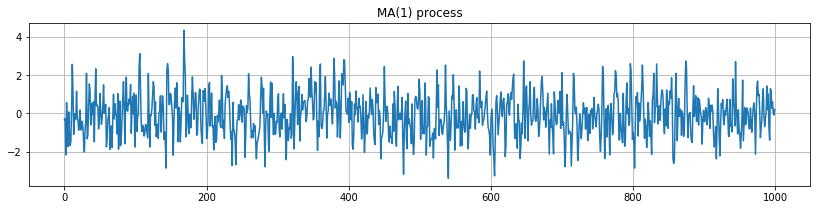

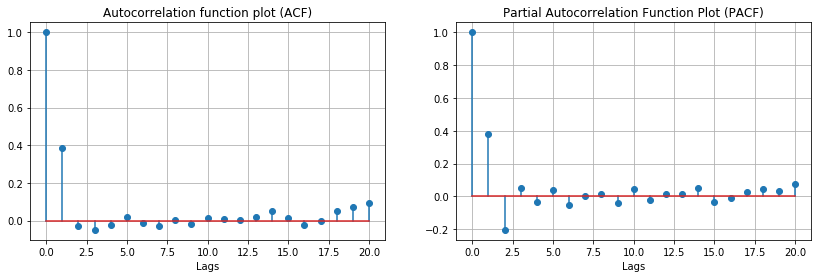

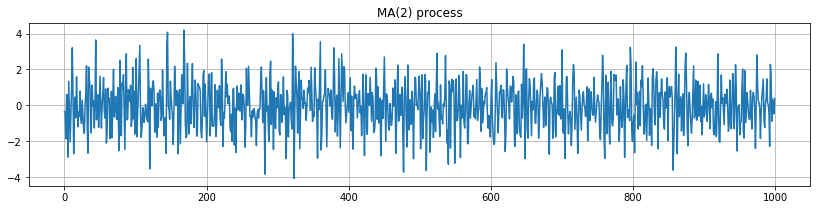

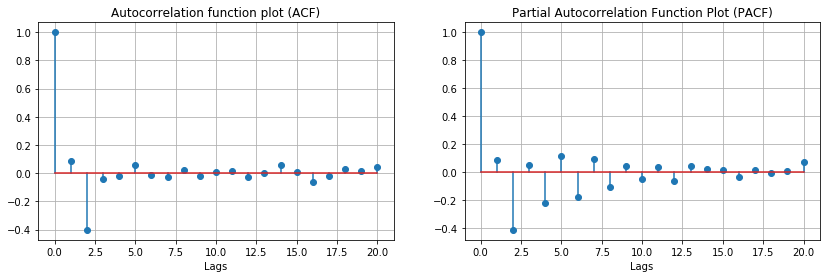

In [19]:
n_samples = int(1000) # number of samples
# beta parameter
b1 = 0.5
# random signal
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up MA(1) process
for t in range(n_samples):
    x[t] = b1*w[t-1] + w[t]
    
# plot MA    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('MA(1) process')
plt.plot(x)
plot_ACF_PAFC(x, 20)

n_samples = int(1000) # number of samples
# beta parameter
b1 = 0.5
b2 = -0.7
# random signal
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up MA(2) process
for t in range(n_samples):
    x[t] = b2*w[t-2] + b1*w[t-1] + w[t]
    
# plot MA    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('MA(2) process')
plt.plot(x)
plot_ACF_PAFC(x,20)

### Analysis of the generated MA processes:
* ACF that drops sharply after a few lags: the shape has one or more spikes and the rest are essentially zero
* PACF decreases more gradually

### Example 3: ARMA process

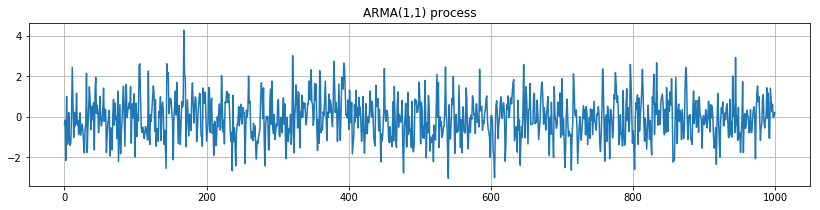

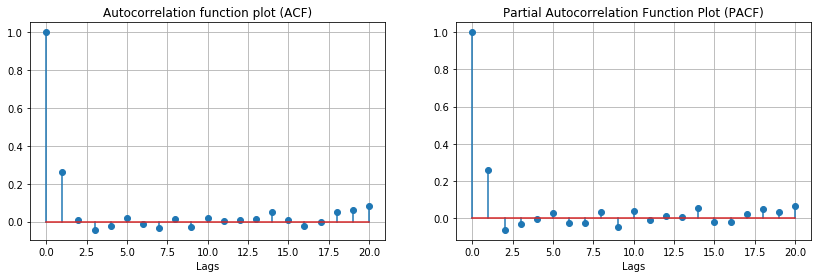

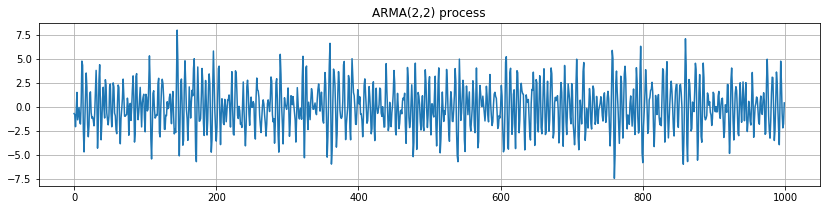

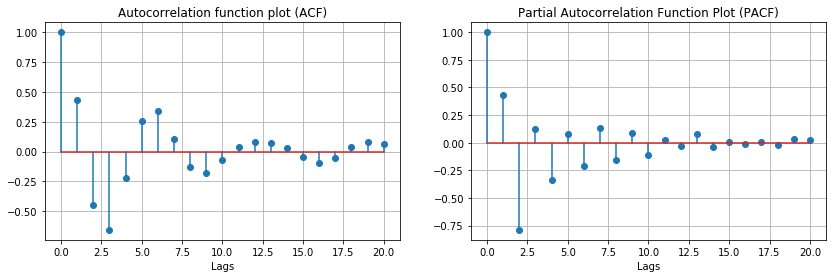

In [20]:
n_samples = int(1000) # number of samples
# alpha parameter
c = 0
a1 = 0.1 
b1 = 0.2
# random signal
np.random.seed(1)
x = np.random.normal(size=n_samples)
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up ARMA(1,1) process
for t in range(n_samples):
    x[t] = c + a1*x[t-1] + b1*w[t-1] + w[t]
    
# plot ARMA    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('ARMA(1,1) process')
plt.plot(x)
plot_ACF_PAFC(x, 20)

n_samples = int(1000) # number of samples
# alpha parameter
c = 0
a1 = 0.8
a2 = -0.65
b1 = 0.5
b2 = -0.7
# random signal
np.random.seed(1)
x = np.random.normal(size=n_samples)
np.random.seed(2)
w = np.random.normal(size=n_samples) 
# build up ARMA(2,2) process
for t in range(n_samples):
    x[t] = c + a2*x[t-2] + a1*x[t-1] + b2*w[t-2] + b1*w[t-1] + w[t]
    
# plot ARMA    
plt.figure(figsize=(14,3))
plt.grid()
plt.title('ARMA(2,2) process')
plt.plot(x)
plot_ACF_PAFC(x,20)


### Analysis of the generated ARMA processes:
* ACF is a mixture of exponentials and damped sine waves after (q-p) lags
* ACF not exponentially or sharply dropping to zero
* ACF decay starting after a few lags
* PACF is a mixture of exponentials and damped sine waves after (p-q) lags.

## Model Identification
https://people.duke.edu/~rnau/411arim2.htm

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

As previously stated:

**AR and MA signatures**: If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "**AR signature**", meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. You will probably find that an AR signature is commonly associated with positive autocorrelation at lag 1--i.e., it tends to arise in series which are slightly underdifferenced. The reason for this is that an AR term can act like a "partial difference" in the forecasting equation.

An "**MA signature**" is commonly associated with negative autocorrelation at lag 1. If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.

**Mixed models**: In most cases, the best model turns out a model that uses either only AR terms or only MA terms, although in some cases a "mixed" model with both AR and MA terms may provide the best fit to the data. However, care must be exercised when fitting mixed models. It is possible for an AR term and an MA term to cancel each other's effects, even though both may appear significant in the model (as judged by the t-statistics of their coefficients).
so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge.

**Unit roots**: If a series is grossly under- or overdifferenced--i.e., if a whole order of differencing needs to be added or cancelled, this is often signalled by a "unit root" in the estimated AR or MA coefficients of the model. 
* If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should *reduce* the number of AR terms by one and *increase* the order of differencing by one.
* If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should *reduce* the number of MA terms by one and *reduce* the order of differencing by one.
* If the long-term forecasts appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

### Preliminary Test: identifing a previously defined ARMA(2,2)

In [21]:
from statsmodels.tsa.arima_model import ARIMA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1423.886
Method:                           mle   S.D. of innovations              1.003
Date:                Sat, 08 Jun 2019   AIC                           2857.773
Time:                        14:12:35   BIC                           2882.312
Sample:                             0   HQIC                          2867.099
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8111      0.037     21.935      0.000       0.739       0.884
ar.L2.y       -0.6723      0.025    -27.211      0.000      -0.721      -0.624
ma.L1.y        0.4691      0.049      9.634      0.0

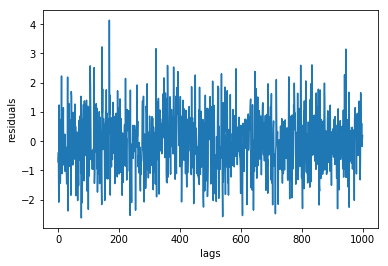

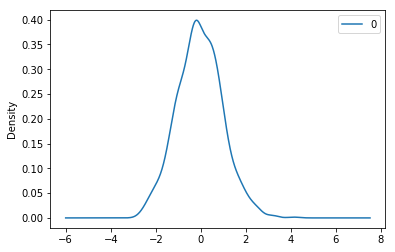

In [22]:
n_samples = 1000
# random signal
np.random.seed(1)
x = np.random.normal(size=n_samples)
np.random.seed(2)
w = np.random.normal(size=n_samples) 
arma2 = []
# build up ARMA(2,2) process
c = 0
a1 = 0.8
a2 = -0.65
b1 = 0.5
b2 = -0.2
for t in range(n_samples):
    x[t] = c + a2*x[t-2] + a1*x[t-1] + b2*w[t-2] + b1*w[t-1] + w[t]
    arma2.append(x[t])
arma2 = pd.Series(arma2)

# plot residual errors
model = ARIMA(arma2, order=(2,0,2))
model_fit = model.fit(method='mle', trend='nc')  # trend: ‘c’ includes constant, ‘nc’ no constant.
residuals = pd.DataFrame(model_fit.resid)
print(model_fit.summary())
plt.ylabel('residuals')
plt.xlabel('lags')
plt.plot(residuals)
residuals.plot(kind='kde')
print(residuals.describe())

## Model Selection and Identification quality:
https://www.statlect.com/glossary/log-likelihood
https://www.vosesoftware.com/riskwiki/ComparingfittedmodelsusingtheSICHQICorAICinformationcritereon.php

The model summary reveals a lot of information. 

The first table reports general informations, particular attention can be payed to the selected method: we choose '**mle**' (maximum likelihood estimator) where likelihood is maximized via the Kalman Filter, the others available are '**css-mle**' where conditional sum of squares likelihood is maximized and its values are used as starting values for the computation of the exact likelihood via the Kalman filter and finally “**css**” where the conditional sum of squares likelihood is maximized.

Considering now the top-right column we can analyse the model selection parameters:
* **Log-likelyhood**: log of the likelihood function that is the joint probability distribution of observed data expressed as a function of statistical parameters (e.g. The parametric family considered as the set of all normal distributions). The log-likelihood function is typically used to derive the maximum likelihood estimator  that maximizes the log-likelihood of the observed sample.
* **S.D. of Innovations**: innovation is the difference between the observed value of a variable at time t and the optimal forecast of that value based on information available prior to time t. If the forecasting method is working correctly, successive innovations are uncorrelated with each other, i.e., constitute a white noise time series.
* **AIC**: Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. As an example, suppose that there are three candidate models, whose AIC values are 100, 102, and 110. Then the second model is exp((100 − 102)/2) = 0.368 times as probable as the first model to minimize the information loss. Similarly, the third model is exp((100 − 110)/2) = 0.007 times as probable as the first model to minimize the information loss. When the sample size is small, there is a substantial probability that AIC will select models that have too many parameters, i.e. that AIC will overfit (see AICc).
* **BIC**: Based, in part, on the likelihood function and it is closely related to the Akaike information criterion (AIC). When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model; the penalty term is larger in BIC than in AIC. Is only valid for sample size n much larger than the number k of parameters in the model and cannot handle complex collections of models as in the variable selection (or feature selection) problem in high-dimension. Model with the lowest BIC is preferred.
* **HQIC**: while often cited, seems to have seen little use in practice. Like BIC, but unlike AIC, is not asymptotically efficient; however, it misses the optimal estimation rate by a very small ln ln n factor. 

AIC, BIC and HQIC are useful for comparing models, but they do not tell anything about the goodness of fit of a single, isolated model. 

The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms, in our case we had ("hat" means "predicted"):

* a1 = 0.8 ---> a1_hat = 0.811
* a2 = -0.65 ---> a2_hat = -0.67
* b1 = 0.5 ---> b1_hat = 0.47
* b2 = -0.2 ---> b1_hat = -0.21

From the **residuals plotting** we can see that errors are Gaussian and centered on zero, furthermore a zero mean in the residuals confirm that there are not biases in the prediction.


## Grid Searching method
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

#### AIC based grid_search

In [23]:
from sklearn.metrics import mean_squared_error
p = [0,1,2,3,4,5]
d = [0,1,2]
q = [0,1,2,3,4,5]
trends = ['c', 'nc']

In [24]:
# evaluate combinations of p, d and q values for an ARIMA model
import warnings
warnings.filterwarnings("ignore")

def info_loss_AIC(aic_best, aic_compare):
    info_loss = np.exp((aic_best-aic_compare)/2)
    return info_loss


def model_selection(dataset, p_values, d_values, q_values, trends):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    order_list = []
    score_list = []
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for mode in trends:
                    order = [(p,d,q), mode]
                    try:
                        model = ARIMA(dataset, order[0])
                        model_fit = model.fit(method='mle', trend=order[1])
                        aic = model_fit.aic
                        score_list.append(aic)
                        order_list.append(order[0])
                        if aic < best_score:
                            best_score, best_cfg = aic, order[0]
                            print('ARIMA%s mode=%s AIC=%.3f' % (order[0],order[1], aic))
                    except:
                        continue
    gridsc_res = list(zip(order_list, score_list))
    gridsc_res = sorted(gridsc_res, key=lambda elem: elem[1])
    snd_score = gridsc_res[1][1]
    trd_score = gridsc_res[2][1]
    snd_loss = info_loss_AIC(best_score, snd_score)
    trd_loss = info_loss_AIC(best_score, trd_score)
    print('\n')
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score), '\n')
    print('Second ARIMA%s AIC=%.3f  relative likelihood with best ARIMA=%.3f' % (gridsc_res[1][0], snd_score, snd_loss), '\n')
    print('Third ARIMA%s AIC=%.3f relative likelihood with best ARIMA=%.3f' % (gridsc_res[2][0], trd_score, trd_loss), '\n')
    

model_selection(ts_deseas, p, d, q, trends)

results:

ARIMA(0, 0, 0) mode=c AIC=467.622

ARIMA(0, 1, 0) mode=c AIC=454.281

ARIMA(0, 1, 1) mode=c AIC=447.168

ARIMA(0, 2, 1) mode=c AIC=438.810

ARIMA(0, 2, 1) mode=nc AIC=436.860

ARIMA(1, 2, 2) mode=c AIC=435.956

ARIMA(2, 2, 1) mode=c AIC=435.616

ARIMA(2, 2, 1) mode=nc AIC=434.198

ARIMA(2, 2, 2) mode=nc AIC=434.057

                             ARIMA Model Results                              
Dep. Variable:        D2.item_cnt_day   No. Observations:                   32
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -366.736
Method:                           mle   S.D. of innovations          21394.724
Date:                Sat, 08 Jun 2019   AIC                            743.473
Time:                        14:12:37   BIC                            750.801
Sample:                             2   HQIC                           745.902
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ar.L1.D2.item_cnt_day    -0.5257      0.568     -0.926      0.362      -1.639       0.587
ar.L2.D2.item_cnt_day    -0.3004      0.206     -1.457      0.156      -0.705       0.104
ma.L1.D2

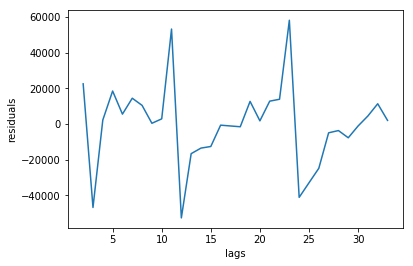

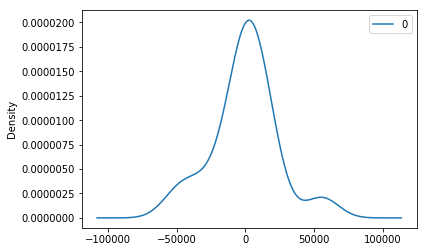

In [25]:
# plot residual errors
model = ARIMA(ts, order=(2,2,2))
model_fit = model.fit(method='mle', trend='nc')  # trend: ‘c’ includes constant, ‘nc’ no constant.
residuals = pd.DataFrame(model_fit.resid)
print(model_fit.summary())
plt.ylabel('residuals')
plt.xlabel('lags')
plt.plot(residuals)
residuals.plot(kind='kde')
print(residuals.describe())

## Model Evaluation:

### Prediction:
Iterative in-sample forecasting from a history. The history was formed of the first 75% of a time series, and a test set was formed by the last 25 %. Here is forecasted the first point of the test set, added the true value to the history, forecasted the second point etc. This shall give an evaluation of the model predictive quality.

A **rolling-forecast scenario** will be used, also called walk-forward model validation.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

This assuming that new observations would be available each month and used in the forecasting of the following month.

This will be simulated by the structure of the train and test datasets.

All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

In [26]:
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    inverted_predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(method='mle', trend='nc')
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        print('predicted: ', yhat, 'observed: ', test[t])

    # calculate out of sample error
    mse = mean_squared_error(test[1:], predictions[1:])
    print('MSE = ', mse, 'RMSE = ', np.sqrt(mse))
    # plot y vs forecast
    model_fit.plot_predict(dynamic=False)
    
    return #mse

predicted:  [127710.35165117] observed:  84419.0
predicted:  [120144.49860287] observed:  82233.0
predicted:  [85886.82019476] observed:  77948.0
predicted:  [76515.82922626] observed:  72435.0
predicted:  [72107.176009] observed:  64237.0
predicted:  [64713.00508597] observed:  63316.0
predicted:  [61767.31842654] observed:  66196.0
predicted:  [61465.56085647] observed:  72989.0
predicted:  [66573.19172499] observed:  69015.0
MSE =  217402043.8778332 RMSE =  14744.559806173706


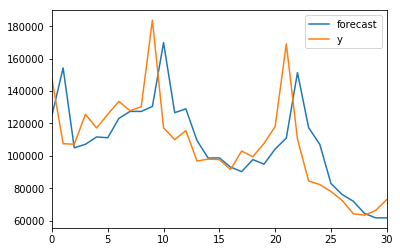

In [27]:
evaluate_arima_model(ts.values, (2,2,2))

## SARIMA:
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle.

ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Trend Elements

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

*    p: Trend autoregression order.
*    d: Trend difference order.
*    q: Trend moving average order.

Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

*    P: Seasonal autoregressive order.
*    D: Seasonal difference order.
*    Q: Seasonal moving average order.
*    m: The number of time steps for a single seasonal period. (For example, an m of 12 for monthly data suggests a yearly seasonal cycle)


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def model_selection_SARIMA(dataset):
    p_params = [0, 1, 2]
    d_params = [0, 1, 2]
    q_params = [0, 1, 2]
    t_params = ['n','c','t']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [10,11,12,13]
    cfg_list=[]
    score_list=[]
    best_score, best_cfg = float("inf"), None
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    try:
                                        model = SARIMAX(dataset, order = cfg[0], seasonal_order=cfg[1], trend=cfg[2])
                                        model_fit = model.fit()
                                        aic = model_fit.aic
                                        score_list.append(aic)
                                        cfg_list.append(cfg)
                                        if aic < best_score:
                                            best_score, best_cfg = aic, cfg
                                            print('SARIMA%s AIC=%.3f' % (cfg,aic))
                                    except:
                                        continue
    print('END')
     

model_selection_SARIMA(ts)

results:

SARIMA[(0, 0, 0), (0, 0, 0, 10), 'n'] AIC=888.500

SARIMA[(0, 0, 0), (0, 1, 0, 10), 'n'] AIC=579.088

SARIMA[(0, 0, 0), (0, 1, 0, 11), 'n'] AIC=547.073

SARIMA[(0, 0, 0), (0, 1, 0, 12), 'n'] AIC=510.520

SARIMA[(0, 0, 0), (0, 1, 0, 13), 'n'] AIC=497.740

SARIMA[(0, 0, 0), (0, 1, 0, 12), 'c'] AIC=467.645

SARIMA[(0, 0, 0), (0, 1, 0, 12), 't'] AIC=463.456

SARIMA[(0, 1, 0), (0, 1, 0, 12), 'n'] AIC=452.511

SARIMA[(0, 2, 0), (0, 1, 0, 12), 'n'] AIC=451.511

SARIMA[(0, 2, 0), (1, 1, 0, 12), 'n'] AIC=448.828

SARIMA[(0, 2, 1), (0, 1, 0, 12), 'n'] AIC=436.356

END

In [29]:
def evaluate_sarima_model(X, sarima_cfg):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order = cfg[0], seasonal_order=cfg[1], trend=cfg[2])
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        print('predicted: ', yhat, 'observed: ', test[t])
    
    # calculate out of sample error
    mse = mean_squared_error(test[1:], predictions[1:])
    print('MSE = ', mse, 'RMSE = ', np.sqrt(mse))
    
    # plot y vs forecast
    predicted = model_fit.fittedvalues
    plt.plot(ts, label='observed')
    plt.plot(predicted, label='forecast')
    plt.legend()
    return train, test, predicted

predicted:  109940.5817518399 observed:  84419.0
predicted:  87359.55047886178 observed:  82233.0
predicted:  60556.75645430541 observed:  77948.0
predicted:  91505.62455629346 observed:  72435.0
predicted:  69404.68158890762 observed:  64237.0
predicted:  55127.232415412065 observed:  63316.0
predicted:  72037.92282101353 observed:  66196.0
predicted:  59727.2585392481 observed:  72989.0
predicted:  78616.29277685116 observed:  69015.0
MSE =  136046639.0261421 RMSE =  11663.903250033502


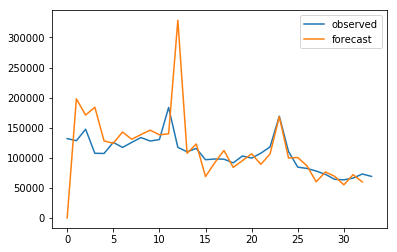

In [30]:
cfg = [(0, 2, 1), (0, 1, 0, 12), 'n']

train, test, predicted = evaluate_sarima_model(ts.values, cfg)

In [31]:
    # invert the forecast to obtain original values
    #forecast_inverted = [inverse_difference(test[i], predictions[i]) for i in range(len(test))]

## A Machine Learning Approach: LSTM
https://skymind.ai/wiki/lstm#long

https://adventuresinmachinelearning.com/keras-lstm-tutorial/

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

A LSTM network is a kind of recurrent neural network. A recurrent neural network is a neural network that attempts to model time or sequence dependent behaviour – such as language, stock prices, electricity demand and so on. This is performed by feeding back the output of a neural network layer at time t to the input of the same network layer at time t + 1.

LSTMs (Long Short-Term Memory units) help preserve the error that can be backpropagated through time and layers (vanishing gradient problem). By maintaining a more constant error, they allow recurrent nets to continue to learn over many time steps (over 1000), thereby opening a channel to link causes and effects remotely thanks to a special architecture which enables it to forget the unnecessary information.

LSTMs contain information outside the normal flow of the recurrent network in a **gated cell**. Information can be stored in, written to, or read from a cell, much like data in a computer’s memory. The cell makes decisions about what to store, and when to allow reads, writes and erasures, via gates that open and close, these gates are analog, implemented with element-wise multiplication by sigmoids, which are all in the range of 0-1. Analog has the advantage over digital of being differentiable, and therefore suitable for backpropagation.

A gated memory cell controlled by its gates is shown below, triple arrows show where information flows into the cell at multiple points:

<img src="lstm.png">

* S_c is the current state of the memory cell
* g_y_in is the current input of the memory cell

The combination of present input and past cell state is fed not only to the cell itself, but also to each of its three gates, which will decide how the input will be handled. The black dots are the gates themselves, which determine respectively whether to let **new** input in, **erase** the present cell state, and/or let that state **impact** the network’s output at the present time step.

<img src="lstm2.png">

The central **plus sign** in both diagrams is essentially the secret of LSTMs, helping them to preserve a constant error when it must be backpropagated at depth.

Different sets of weights filter the input for input, output and forgetting. The forget gate is represented as a linear identity function, because if the gate is open, the current state of the memory cell is simply multiplied by one, to propagate forward one more time step. In the diagram below, you can see the gates at work, with straight lines representing closed gates, and blank circles representing open ones. The lines and circles running horizontal down the hidden layer are the forget gates.

<img src="lstm3.png">

In [32]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')

#it or want to work on dates then we have convert it on datetime format
train_df['date'] = pd.to_datetime(train_df['date'],format = '%d.%m.%Y')

# cleaning again
train_df = train_df[train_df.item_price<100000]
train_df = train_df[train_df.item_cnt_day<800]

# healing again
median = train_df['item_price'].median()  # compute the median value
train_df.loc[train_df.item_price<0, 'item_price'] = median
train_df.loc[train_df.item_cnt_day<0, 'item_cnt_day'] = 0

ts=train_df.groupby(["date_block_num"])["item_cnt_day"].sum() # extract the count of the items sold per month 

# transform data to be stationary
ts_deseas = difference_ts(ts.values, 12)

print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935846 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.8 MB
None


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,0.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### Data Preparation:
https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

Univariate time series forecasting problems are actually simpler than the types of problems traditionally used to demonstrate the capabilities of LSTMs. They often do not require RNNs at all, because all relevant information about the next event is conveyed by a few recent events contained within a small time window.

The LSTM is exposed to one input at a time with no fixed set of lag variables, this may suggest that LSTMs may not be suited to AR type formulations of time series forecasting, at least when the lagged observations are close to the time being forecasted. LSTM can learn to tune into the fundamental oscillation of each series but may be unable to accurately follow the signal if the latter is too fast.

Before we can fit an LSTM model to the dataset, we must transform the data.
The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.

* **Transform the time series data so that it is stationary**. Specifically, a lag=12 differencing to remove the seasonality in the data (see above).
* **Transform the time series into a supervised learning problem**. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step
* **Transform the observations to have a specific scale**. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.

In [33]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

In [39]:
# demo from ts to featured
features = 1
ts_sv = timeseries_to_supervised(ts_deseas, features)
ts_sv.columns = ['t', 't+1']
ts_sv = ts_sv.dropna()
supervised_values = ts_sv.values[features:,:]

# split data into train and test-sets
train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
print('train_set lags=',len(train),' test_set lags=',len(test),)

ts_sv.head()

train_set lags= 8  test_set lags= 12


,t,t+1
1,-14607.0,-18407.0
2,-18407.0,-31937.0
3,-31937.0,-10695.0
4,-10695.0,-9210.0
5,-9210.0,-27960.0


In [40]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]



### Initial LSTM model
We will use a base stateful LSTM model with 1 neuron fit for 500 epochs.

A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 12 months of test data.

A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.

Ideally, more training epochs would be used (such as 1000 or 1500).

The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print('LSTM model in training...')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

#### Preliminary experiments
We will perform 5 experiments; each will use a different number of lag observations as features from 1 to 5.

A representation with a 1 input feature would be the default representation when using a stateful LSTM. Using 2 to 5 features is contrived. The hope would be that the additional context from the lagged observations may improve performance of the predictive model.

The univariate time series is converted to a supervised learning problem before training the model. The specified number of features defines the number of input variables (X) used to predict the next observation (y). As such, for each feature used in the representation, that many rows must be removed from the beginning of the dataset. This is because there are no prior observations to use as features for the first values in the dataset.

Each experimental scenario will be **run 10 times**.

The reason for this is that the random initial conditions for an LSTM network can result in very different results each time a given configuration is trained.

In [42]:
from math import sqrt

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, features, batch_size, nb_epoch, neurons, split_point):
    rmse_best = float("inf")
    best_forecast = []
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference_ts(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, features)
    supervised_values = supervised.values[features:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-split_point, :], supervised_values[-split_point:, :]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the base model
        lstm_model = fit_lstm(train_scaled, batch_size, nb_epoch, neurons)
        # forecast test dataset
        predictions = list()
        for i in range(len(test_scaled)):
            # predict
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
            print('predicted=', yhat, ' observed=', raw_values[i])
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-split_point:], predictions))
        if rmse < rmse_best:
            print('Best Score ---> RMSE: %.3f' % (rmse))
            rmse_best = rmse
            best_forecast = predictions
        print('%d) Test Score RMSE: %.3f' % (r+1, rmse), '-> END \n')
        error_scores.append(rmse)
    return best_forecast, raw_values, error_scores 

### LSTM hyperparameters tuning
https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

* **number of epochs**: number of training epochs used during training
* **features**: lag observations for a univariate time series can be used as features for an LSTM and whether or not this may improves forecast performance. *features* parameter defines the number of input variables (X) used to predict the next observation (y). As such, for each feature used in the representation, that many rows must be removed from the beginning of the dataset. This is because there are no prior observations to use as features for the first values in the dataset
* **batch_size**: controls how often to update the weights of the network. A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 12 months of test data. A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.
* **repeats**: run the scenario for n-times, The reason for this is that the random initial conditions for an LSTM network can result in very different results each time a given configuration is trained.
* **neurons**: The number of neurons affects the learning capacity of the network. Generally, more neurons would be able to learn more structure from the problem at the cost of longer training time. More learning capacity also creates the problem of potentially overfitting the training data.

In [54]:
series = ts_deseas
repeats = 10
features = 1
batch_size = 1
nb_epoch = 1500
neurons = 1
split_point = 12
results = pd.DataFrame()

# run experiment
bestforecast, raw_values, results['results'] = experiment(repeats, 
                                                          series, 
                                                          features, 
                                                          batch_size, 
                                                          nb_epoch, 
                                                          neurons, 
                                                          split_point)


LSTM model in training...
predicted= -20415.819522947073  observed= -14607.0
predicted= -12443.819522947075  observed= -18407.0
predicted= -14837.819522947075  observed= -31937.0
predicted= -7167.819522947074  observed= -10695.0
predicted= -25779.819522947073  observed= -9210.0
predicted= -33491.81952294707  observed= -27960.0
predicted= -19019.819522947073  observed= -25660.0
predicted= -25726.819522947073  observed= -22676.0
predicted= -33609.81952294707  observed= -34124.0
predicted= -28412.819522947073  observed= -20192.0
predicted= -36937.81952294707  observed= -12220.0
predicted= -26661.819522947073  observed= -14614.0
Best Score ---> RMSE: 9984.595
1) Test Score RMSE: 9984.595 -> END 

LSTM model in training...
predicted= -33388.43487930298  observed= -14607.0
predicted= -25416.43487930298  observed= -18407.0
predicted= -26150.909816026688  observed= -31937.0
predicted= -19364.068024158478  observed= -10695.0
predicted= -16433.717886447906  observed= -9210.0
predicted= -16727.72

            results
count     10.000000
mean   11593.200820
std     3124.605308
min     9037.711234
25%     9984.594803
50%     9984.616565
75%    11807.587593
max    18738.360295


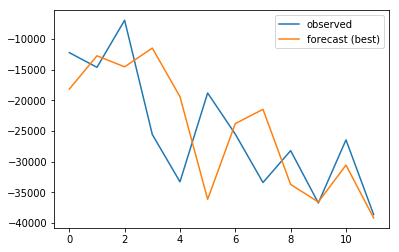

In [55]:
print(results.describe())

plt.plot(raw_values[-len(bestforecast):], label='observed')
plt.plot(bestforecast, label='forecast (best)')
plt.legend()

##### LSTM extensions:
* **Dropout**: Slow down learning with regularization methods like dropout on the recurrent LSTM connections.
* **Layers**: Explore additional hierarchical learning capacity by adding more layers and varied numbers of neurons in each layer.
* **Regularization**: Explore how weight regularization, such as L1 and L2, can be used to slow down learning and overfitting of the network on some configurations.
* **Optimization Algorithm**: Explore the use of alternate optimization algorithms, such as classical gradient descent, to see if specific configurations to speed up or slow down learning can lead to benefits.
* **Loss Function**: Explore the use of alternative loss functions to see if these can be used to lift performance.

### Stacked LSTM
https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer.
The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells making the model deeper and more accurate at earning the description as a deep learning technique. The success of deep neural networks is commonly attributed to the hierarchy that is introduced due to the several layers. Each layer processes some part of the task we wish to solve, and passes it on to the next.

Given that LSTMs operate on sequence data, it means that the addition of layers adds levels of abstraction of input observations over time. In effect, chunking observations over time or representing the problem at different time scales.

A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.
<img src="lstm4.png">

Each LSTMs memory cell requires a **3D input**. When an LSTM processes one input sequence of time steps, each memory cell will output a single value for the whole sequence as a 2D array.

To stack LSTM layers, we need to change the configuration of the top LSTM layer to output a 3D array as input for the subsequent layer.
We can do this by setting the return_sequences argument on the layer to True (defaults to False). This will return one output for each input time step and provide a 3D array.


In [56]:
# fit an stacked LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(LSTM(neurons, return_sequences=True, stateful=True))
    model.add(LSTM(neurons, return_sequences=True, stateful=True))
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print('LSTM model in training...')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [57]:
# run experiment
bestforecast, raw_values, results['results'] = experiment(repeats, series, 
                                                          features, 
                                                          batch_size, 
                                                          nb_epoch, 
                                                          neurons, 
                                                          split_point)

LSTM model in training...
predicted= -19457.452690139413  observed= -14607.0
predicted= -11436.001232564451  observed= -18407.0
predicted= -13803.864273585381  observed= -31937.0
predicted= -6121.450178071857  observed= -10695.0
predicted= -24727.29905436188  observed= -9210.0
predicted= -32436.050282530487  observed= -27960.0
predicted= -17962.231847807765  observed= -25660.0
predicted= -24668.169533014297  observed= -22676.0
predicted= -32550.532077096403  observed= -34124.0
predicted= -27353.143383555114  observed= -20192.0
predicted= -35877.90467745066  observed= -12220.0
predicted= -25601.757148213685  observed= -14614.0
Best Score ---> RMSE: 10181.768
1) Test Score RMSE: 10181.768 -> END 

LSTM model in training...
predicted= -19564.366804137826  observed= -14607.0
predicted= -12129.589995250108  observed= -18407.0
predicted= -14781.093060135843  observed= -31937.0
predicted= -7251.123148739339  observed= -10695.0
predicted= -25927.837867200375  observed= -9210.0
predicted= -3367

            results
count     10.000000
mean   10602.443492
std     1873.358144
min     9900.265378
25%     9982.251555
50%     9984.432396
75%    10132.352617
max    15927.074146


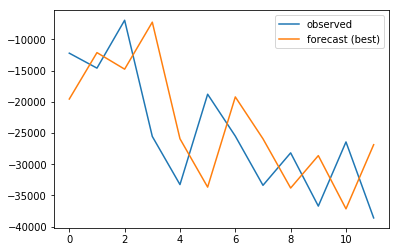

In [58]:
print(results.describe())

plt.plot(raw_values[-len(bestforecast):], label='observed')
plt.plot(bestforecast, label='forecast (best)')
plt.legend()

#https://www.youtube.com/?gl=IT&hl=it